In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from Correlation_n_covariance import variance
import csv  

In [49]:
def abs_avg_deviation(y_true,y_pred):
    deviation = 0
    for i in range(len(y_true)):
        deviation += np.abs(y_pred[i]-y_true[i])/np.abs(y_true[i])
    deviation *= 1./len(y_true)
    return deviation

def R2_coef(y_true,y_pred):
    """
    Calculates coefficient of determination 
    """
    u,v = 0,0
    for i in range(len(y_true)):
        u += (y_true[i] - y_pred[i])**2
        v += (y_true[i] - np.mean(y_true))**2
    return float(1 - u/v)

def normalize_data(vectors, labels):
    """ Normalizing s.t. each feature (column) has mean = 0 and then variance = 1 """
    # Labels
    Label_mean, Label_var = np.mean(labels), np.std(labels) 
    labels = labels - Label_mean     ## mean
    labels = labels * 1./Label_var   ## variance

    # Feature vectors
    for col in range(vectors.shape[1]):
        vectors[:,col] = vectors[:,col] - np.mean(vectors[:,col])    ## mean
        vectors[:,col] = vectors[:,col] * 1./np.std(vectors[:,col])  ## variance
    
    return (Label_mean, Label_var, vectors, labels)

def remove_const_cols(training,validation):
    keep_indices = []
    for col in range(training.shape[1]):
        if not np.all(training[:,col][0]==training[:,col]):
            keep_indices.append(col)
    return training[:,keep_indices], validation[:,keep_indices]

def write_out_prediction(test_filepath,test_label_pred,prediction_nr):
    Test_data = pd.read_csv(test_filepath)
    Test_data_Id = Test_data.values[:,0]
    id_n_prediction = []
    for i in range(len(Test_data_Id)):
        id_n_prediction.append([int(Test_data_Id[i]),test_label_pred[i]])
    id_n_prediction = np.array(id_n_prediction)

    header = ['Id', 'SalePrice']
    with open('Submissions/predictions'+str(prediction_nr)+'.csv', 'w', ) as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        for i in range(len(Test_data_Id)):
            writer.writerow([int(id_n_prediction[i][0]),id_n_prediction[i][1]])


In [32]:
class Data:
    def __init__(self,filepath,labelname,validation_fraction = 0.2,data_type = "Training data",encoder_type="K vals"):
        assert type(filepath) is str and type(labelname) is str, " 'Filepath' or 'labelname' is not given as string"
        assert data_type == "Training data" or data_type == "Test data", "wrong specification of datatype"
        assert encoder_type == "K vals" or encoder_type == "One hot", "Wrong specification of encoder type"

        self.filepath  = filepath
        self.labelname = labelname

        self.data              = self.initiate_data()
        if data_type == "Training data":
            self.labels = self.data[labelname].values
        self.nof_feature_vecs  = self.data.shape[0] # Total number of feature vectors in inital data
        self.feature_names     = self.initiate_feature_names()
        if data_type == "Training data":
            if encoder_type == "K vals":
                self.label_col_index   = np.argwhere(self.feature_names == self.labelname)
            if encoder_type == "One hot":
                self.label_col_index   = -1

        
        self.NaN_features      = self.initiate_Nan_features(encoder_type)
        if encoder_type == "K vals":
            self.NaN_feature_dicts = self.initiate_Nan_dict()
        self.encoded_data      = self.initiate_encoded_data(encoder_type)

        self.test_vectors       = None
        self.validation_labels  = None
        self.validation_vectors = None
        self.training_labels    = None
        self.training_vectors   = None
        self.initiate_feature_vectors(data_type,validation_fraction,encoder_type)


    def initiate_data(self):
        return pd.read_csv(self.filepath)
    
    def initiate_feature_names(self):
        return self.data.columns

    def initiate_labels(self):
        return self.data[self.labelname].values 

    def initiate_Nan_features(self,encoder_type):
        ''' Getting features not represented by a number ''' 
        if encoder_type == "K vals": 
            NaN_features = []
            for index, datatype in enumerate(self.data.dtypes):
                if datatype == "O" or datatype == object:
                    NaN_features.append(self.data.columns[index])
            return np.array(NaN_features)
        if encoder_type == "One hot":
            data = self.data.values
            NaN_features_idx = []
            for row in range(data.shape[0]):
                for col in range(data.shape[1]):
                    if type(data[row][col]) is str:
                        if col not in NaN_features_idx:
                            NaN_features_idx.append(col)
            NaN_features_idx = np.sort(NaN_features_idx,kind='heapsort')
            return np.array(NaN_features_idx)
    
    def initiate_Nan_dict(self):
        ''' Dictionary of dictionaries:
            A dictionary for each NaN feature, mapping k'th possible 
            val for that feature to int(k) (simple integer encoding)
            
            Return:  dict(dict_1,...,dict_#NanFeatures)'''
        NaN_feature_dicts = {}
        for feature_idx,feature in enumerate(self.NaN_features):
            ith_feature_dict = {}
            for val_idx, possible_val in enumerate(np.unique(list(self.data[self.NaN_features[feature_idx]]))):
                ith_feature_dict[str(possible_val)] = val_idx
            NaN_feature_dicts[feature] = ith_feature_dict   
        return NaN_feature_dicts

    def initiate_feature_vectors(self, data_type, validation_fraction,encoder_type):
        assert data_type == "Training data" or data_type == "Test data", "Wrong kind of data suggested in type"
        if encoder_type == "One hot":
            data = self.encoded_data
        if encoder_type == "K vals":
            data = self.encoded_data.values

        if data_type == "Training data":
            """ Setting "validation_fraction" % of data aside for validation (randomly chosen) """
            random_indices = np.random.choice([i for i in range(self.data.values.shape[0])],
                                              size=int(self.nof_feature_vecs * validation_fraction),replace=False)
            validation_vectors = data[random_indices]
            remaining_indices = np.array([i for i in range(self.nof_feature_vecs) if i not in random_indices])
            training_vectors  = data[remaining_indices]
            # Getting labels
            validation_labels = validation_vectors[:,self.label_col_index]
            validation_labels = validation_labels.astype("float64").reshape(len(validation_labels),1)
            training_labels   = training_vectors[:,self.label_col_index]
            training_labels   = training_labels.astype("float64").reshape(len(training_labels),1)
            # Removing label-column, and idcolumn
            validation_vectors = validation_vectors[:,[i+1 for i in range(validation_vectors.shape[1]-2)]] 
            training_vectors = training_vectors[:,[i+1 for i in range(training_vectors.shape[1]-2)]] 
            ## Assuring appropriate dtype of all entries in array (also setting any Nan = 0)
            validation_vectors = validation_vectors.astype("float64")
            validation_vectors = np.nan_to_num(validation_vectors)
            training_vectors = training_vectors.astype("float64")
            training_vectors = np.nan_to_num(training_vectors)  
            self.training_labels = training_labels
            self.validation_labels = validation_labels
            self.validation_vectors = validation_vectors
            self.training_vectors = training_vectors
        if data_type == "Test data":
            test_vectors = data
            # Removing label-column, and idcolumn
            test_vectors = test_vectors[:,[i+1 for i in range(test_vectors.shape[1]-1)]] 
            ## Assuring appropriate dtype of all entries in array (also setting any Nan = 0)
            test_vectors = test_vectors.astype("float64")
            test_vectors = np.nan_to_num(test_vectors)
            self.test_vectors = test_vectors
    
    def col_2_matrix(self,col):
        """Helper function for One hot encoding of a column"""
        different_values = np.unique(col)
        matrix = np.zeros((len(col),len(different_values)))
        for row in range(len(col)):
            matrix[row][np.argwhere(col[row] == different_values)] = 1
        return matrix

    def initiate_encoded_data(self,encoder_type):
        """ Mapping all NaN features to numbers in compliance with dictionaries """
        if encoder_type == "K vals":
            data = deepcopy(self.data)
            for feature in self.NaN_features:
                current_dict = self.NaN_feature_dicts[feature] 
                for index in range(len(list(self.data[feature]))):
                    value = current_dict[str(self.data.at[index,feature])] ## Getting
                    data.at[index,feature] = value                         ## Setting
            return data
        if encoder_type == "One hot":
            data = self.data.values
            init_mat = np.zeros((data.shape[0],1))
            for col in range(data.shape[1]):
                if col in self.NaN_features:
                    one_hot_mat = self.col_2_matrix(data[:,col].astype(str))
                    init_mat = np.concatenate([init_mat,one_hot_mat],axis=1)
                else:
                    init_mat = np.concatenate([init_mat,data[:,col].reshape(data.shape[0],1)],axis=1)
            init_mat = init_mat[:,[i+1 for i in range(init_mat.shape[1]-1)]]     
            return init_mat


In [71]:
######## Loading data ########
# Training data
my_training_data = Data(filepath="Data/train.csv",labelname='SalePrice',
                        validation_fraction=0.2,data_type="Training data",encoder_type="K vals")

training_vectors = my_training_data.training_vectors
validation_vectors = my_training_data.validation_vectors

training_labels = my_training_data.training_labels
validation_labels = my_training_data.validation_labels


# Test data
my_test_data = Data(filepath="Data/test.csv",labelname='SalePrice',data_type="Test data")
test_vectors = my_test_data.test_vectors

# Removing zero columns
training_vectors, validation_vectors = remove_const_cols(training_vectors,validation_vectors)
training_vectors.shape

(1168, 79)

In [72]:
## Normalizing s.t. each feature (column) has mean = 0 and then variance = 1 
Training_Label_mean, Training_Label_var, Training_vectors, Training_labels  = normalize_data(training_vectors,
                                                                                             training_labels)
Valid_Label_mean, Valid_Label_var, Valid_vectors, Valid_labels  = normalize_data(validation_vectors,
                                                                                validation_labels)

_,_,Test_vectors,_ = normalize_data(test_vectors,np.ones(len(test_vectors)))

## Removing Nans
Training_X_norm_Ada = np.nan_to_num(Training_vectors)  
Validation_X_norm_Ada = np.nan_to_num(Valid_vectors)  
Test_X_norm_Ada = np.nan_to_num(Test_vectors)

/var/folders/lf/g00xwz855rs9xhsrn28h139c0000gn/T/ipykernel_2023/2109800462.py:28: RuntimeWarning: invalid value encountered in true_divide
  vectors[:,col] = vectors[:,col] * 1./np.std(vectors[:,col])  ## variance
/var/folders/lf/g00xwz855rs9xhsrn28h139c0000gn/T/ipykernel_2023/2109800462.py:23: RuntimeWarning: invalid value encountered in true_divide
  labels = labels * 1./Label_var   ## variance


## Regression tree with Adaboost

In [77]:
"""    regression_loss_funcs = ['linear','square','exponential']
    base_reg = DecisionTreeRegressor(max_depth=15)
    reg = AdaBoostRegressor(base_estimator=base_reg, n_estimators=68, 
                            learning_rate = 0.5, loss=regression_loss_funcs[1], random_state=0) """

Valid_deviations, Training_deviations = [], []
Valid_R2_vals, Training_R2_vals = [], []
for i in range(1,20):
    ######### Fit regression model #########
    regression_loss_funcs = ['linear','square','exponential']
    base_reg = DecisionTreeRegressor(max_depth=i)
    reg = AdaBoostRegressor(base_estimator=base_reg, n_estimators=68, 
                            learning_rate = 0.5, loss=regression_loss_funcs[1], random_state=0)

    ## Training model on training data
    reg.fit(Training_X_norm_Ada, Training_labels.flatten())

    ## Predictions
    Valid_labels_prediction    = reg.predict(Validation_X_norm_Ada) * Valid_Label_var + Valid_Label_mean
    Training_labels_prediction = reg.predict(Training_X_norm_Ada) * Training_Label_var + Training_Label_mean
    Valid_labels_true = Valid_labels * Valid_Label_var + Valid_Label_mean
    Training_labels_true = Training_labels * Training_Label_var + Training_Label_mean

    ## Scoring
    Valid_deviation = abs_avg_deviation(Valid_labels_true,Valid_labels_prediction)
    Training_deviation = abs_avg_deviation(Training_labels_true,Training_labels_prediction)
    Valid_deviations.append(Valid_deviation), Training_deviations.append(Training_deviation)

Best valid =  0.10118035691369873
Iteration index =  14


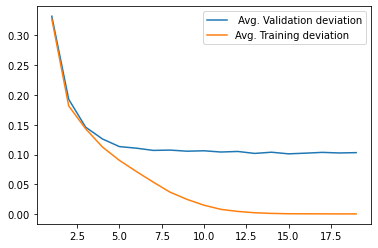

In [78]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

max_depth = [i+1 for i in range(len(Valid_deviations))]

#ax.plot(max_depth,Valid_R2_vals,label='Validation R2')
#ax.plot(max_depth,Training_R2_vals,label='Training R2')

ax.plot(max_depth,Valid_deviations,label=' Avg. Validation deviation')
ax.plot(max_depth,Training_deviations,label='Avg. Training deviation')
ax.legend()
print("Best valid = ",np.min(Valid_deviations))
print("Iteration index = ", np.argmin(Valid_deviations))
plt.show()

## Regression tree with gradient boost

In [148]:
"""reg = GradientBoostingRegressor(loss=regression_loss_funcs[0], learning_rate=0.097, n_estimators=128, 
                                    subsample=1.0, criterion='friedman_mse', max_depth=4, 
                                    min_impurity_decrease=0.0, random_state=0, 
                                    max_features=None, alpha=0.9, max_leaf_nodes=None, 
                                    validation_fraction=0.2, n_iter_no_change=None, # Any int -> using early stopping 
                                    tol=0.0001, ccp_alpha=0.0)
"""
Valid_deviations, Training_deviations = [], []
Valid_R2_vals, Training_R2_vals = [], []
for i in range(1,30):
    ######### Fit regression model #########
    ## Loss functions
    regression_loss_funcs = ['squared_error', 'absolute_error', 'huber', 'quantile']
    ## Defining model (using 20% for validation set and using early stopping)
    reg = GradientBoostingRegressor(loss=regression_loss_funcs[0], learning_rate=0.097, n_estimators=128, 
                                    subsample=1.0, criterion='friedman_mse', max_depth=i, 
                                    min_impurity_decrease=0.0, random_state=0, 
                                    max_features=None, alpha=0.9, max_leaf_nodes=None, 
                                    validation_fraction=0.2, n_iter_no_change=None, # Any int -> using early stopping 
                                    tol=0.0001, ccp_alpha=0.0)

    ## Training model on training data
    reg.fit(Training_X_norm_Ada, Training_labels.flatten())

    ## Predictions
    Valid_labels_prediction    = reg.predict(Validation_X_norm_Ada) * Valid_Label_var + Valid_Label_mean
    Training_labels_prediction = reg.predict(Training_X_norm_Ada) * Training_Label_var + Training_Label_mean
    Valid_labels_true = Valid_labels * Valid_Label_var + Valid_Label_mean
    Training_labels_true = Training_labels * Training_Label_var + Training_Label_mean

    ## Scoring
    Valid_deviation = abs_avg_deviation(Valid_labels_true,Valid_labels_prediction)
    Training_deviation = abs_avg_deviation(Training_labels_true,Training_labels_prediction)
    Valid_deviations.append(Valid_deviation), Training_deviations.append(Training_deviation)

Best valid =  0.09952466544939903
Iteration index =  4


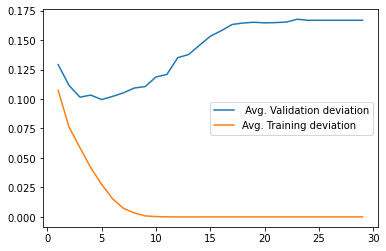

In [149]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

max_depth = [i+1 for i in range(len(Valid_deviations))]

#ax.plot(max_depth,Valid_R2_vals,label='Validation R2')
#ax.plot(max_depth,Training_R2_vals,label='Training R2')

ax.plot(max_depth,Valid_deviations,label=' Avg. Validation deviation')
ax.plot(max_depth,Training_deviations,label='Avg. Training deviation')
ax.legend()
print("Best valid = ",np.min(Valid_deviations))
print("Iteration index = ", np.argmin(Valid_deviations))
plt.show()

## Covariance-variance & Correlation matrix

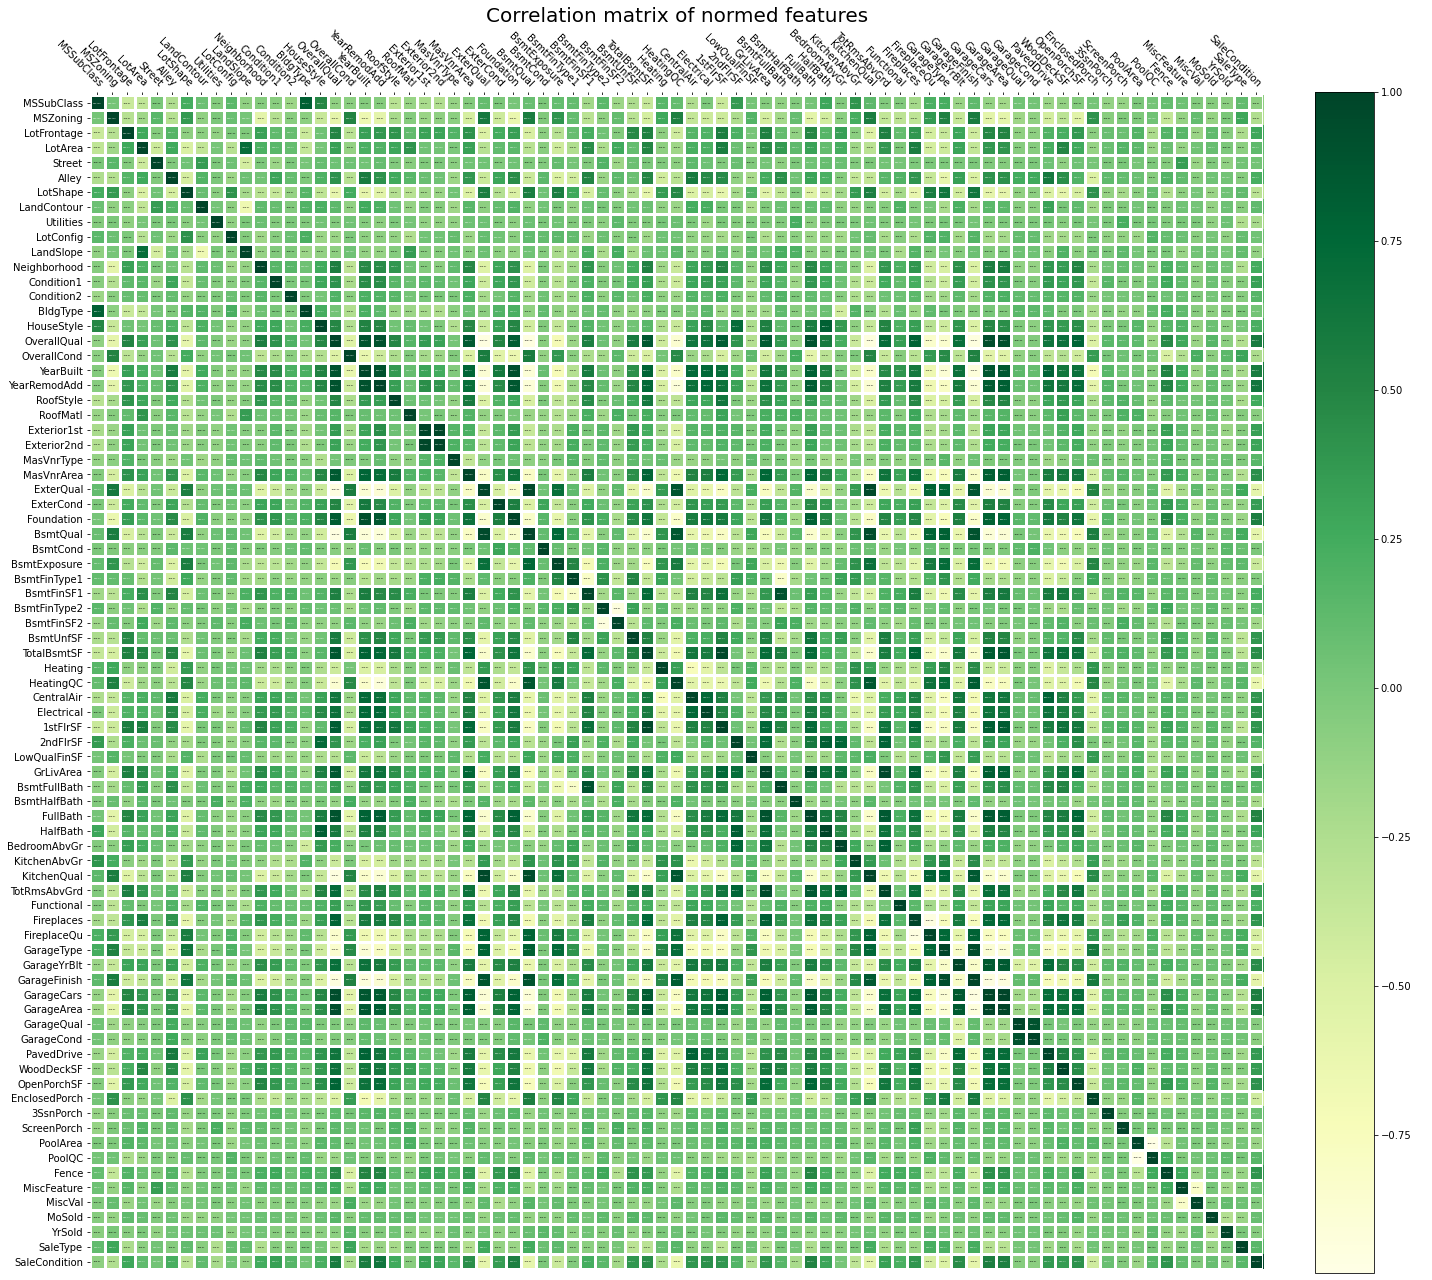

In [162]:
from heatmap_functions import heatmap
from heatmap_functions import annotate_heatmap

from Correlation_n_covariance import correlation_matrix
from Correlation_n_covariance import covariance_matrix


fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.set_title("Correlation matrix of normed features",size=20)
im, cbar = heatmap(data = correlation_matrix(Training_X_norm_Ada.T @ Training_X_norm_Ada), row_labels = my_training_data.feature_names[1:-1], 
                    col_labels = my_training_data.feature_names[1:-1], ax=ax, cbarlabel=" ",cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.1e}",size=2)
fig.tight_layout()
plt.savefig("Correlation-Matrix.jpg",dpi=800)

(1191, 297)

1.0008347245408853

In [10]:
np.random.randint(0,40,20,unique=True)

TypeError: randint() got an unexpected keyword argument 'unique'

In [48]:
test = np.array([1,2,2,2,2,2,2,2])
np.all(test[0]==test)

False